## Data

In [1]:
quantification_dict_8557 = {0: 158, 1033: 29, 728: 60, 846: 8, 91: 19, 7: 3, 773: 2, 951: 1, 711: 1, 989: 11, 372: 1, 202: 72, 512: 37, 209: 2, 616: 45, 984: 67, 867: 148, 534: 7, 658: 11, 612: 2, 313: 205, 1047: 1, 1070: 2, 957: 1, 136: 11, 970: 5, 1048: 23, 976: 158, 866: 7, 850: 12, 147: 2, 145: 34, 771: 60, 898: 61, 1093: 19, 820: 78, 811: 46, 795: 438, 280: 4, 326: 31, 1052: 67, 128: 238, 661: 1, 828: 14, 17: 129, 26: 76, 246: 14, 10: 18, 924: 9, 381: 22, 997: 7, 32767: 33, 797: 75, 178: 3, 81: 8, 108: 9, 1009: 6, 477: 42, 301: 3, 551: 10, 559: 10, 187: 3, 651: 2, 169: 11, 354: 6, 912: 1, 62: 6, 1043: 8, 162: 25, 318: 2, 604: 1, 42: 19, 140: 123, 146: 35, 214: 4, 863: 7, 374: 5, 215: 7, 544: 15, 672: 46, 638: 2, 852: 10, 880: 8, 872: 12, 679: 6, 812: 1, 842: 1, 67: 1, 697: 6, 210: 3, 194: 45, 685: 14, 364: 7, 262: 1, 625: 2, 998: 6, 217: 3, 1091: 7, 350: 2, 798: 1, 460: 2, 681: 1, 231: 2, 35: 1, 336: 1, 12: 2, 634: 1, 50: 2, 186: 41, 595: 3, 690: 1, 1097: 50, 1004: 7, 980: 11, 946: 5, 830: 3, 610: 4, 648: 15, 478: 1, 6: 13, 803: 17, 351: 25, 226: 29, 56: 42, 844: 2, 767: 69, 656: 2, 962: 30, 1007: 3, 445: 2, 749: 4, 158: 2, 118: 2, 129: 2, 443: 1, 362: 20, 802: 1, 575: 7, 64: 2, 549: 6, 88: 7, 943: 11, 523: 28, 258: 2, 342: 39, 1101: 15, 630: 31, 482: 2, 271: 2, 834: 2, 851: 1, 804: 6, 1: 9, 436: 2, 434: 1, 449: 1, 38: 1, 515: 19, 181: 2, 30: 1, 133: 1, 1109: 8, 1015: 7, 1021: 8, 488: 3, 412: 15, 448: 8, 328: 4, 1064: 3, 1029: 2, 580: 1, 422: 1, 102: 2, 614: 2, 356: 1, 965: 2, 906: 1, 774: 3, 914: 1, 263: 1, 72: 1, 266: 1, 272: 1, 363: 21, 304: 5, 707: 7, 171: 7, 211: 2, 827: 5, 556: 5, 620: 4, 698: 14, 608: 1, 1125: 6, 288: 27, 969: 16, 159: 1, 1079: 1, 1031: 1, 670: 1, 1128: 3, 403: 5, 298: 12, 908: 1, 596: 1, 814: 1, 935: 1, 484: 1, 131: 2, 303: 5, 1022: 2, 23: 5, 268: 1, 1108: 1, 956: 9, 1054: 2, 1081: 1, 582: 1, 1090: 2, 1035: 1, 754: 1, 440: 4, 961: 1, 188: 1, 806: 3, 873: 1, 289: 1, 450: 1, 320: 1, 783: 1, 800: 6, 667: 2, 68: 1, 344: 2, 1058: 1, 163: 2, 120: 1}

In [2]:
quantification_dict_8555 = {1090: 1, 728: 17, 1025: 9, 1033: 27, 544: 17, 551: 19, 477: 11, 559: 14, 342: 23, 1105: 1, 327: 2, 32767: 11, 1101: 8, 984: 60, 1091: 6, 850: 1, 326: 3, 867: 5, 512: 2, 313: 26, 811: 38, 828: 11, 271: 1, 549: 2, 128: 10, 1088: 1, 1097: 23, 697: 2, 403: 4, 1031: 1, 268: 1, 23: 18, 698: 4, 952: 2, 583: 2, 202: 1, 976: 50, 820: 19, 17: 44, 26: 8, 58: 2, 381: 2, 1: 10, 797: 11, 804: 1, 470: 1, 725: 2, 733: 4, 194: 15, 1139: 1, 298: 19, 754: 4, 943: 2, 42: 2, 146: 6, 214: 1, 749: 2, 525: 4, 10: 1, 1004: 15, 364: 4, 614: 9, 685: 5, 436: 2, 63: 2, 596: 11, 803: 4, 1094: 1, 412: 10, 630: 10, 773: 1, 651: 2, 872: 1, 140: 6, 812: 1, 679: 2, 795: 4, 126: 4, 980: 2, 1126: 2, 946: 4, 223: 2, 693: 8, 830: 5, 10703: 7, 632: 3, 88: 4, 186: 2, 226: 12, 523: 22, 351: 26, 56: 14, 448: 2, 951: 2, 771: 1, 35: 1, 997: 1, 118: 3, 483: 2, 38: 2, 515: 24, 962: 3, 263: 9, 272: 11, 159: 3, 814: 5, 620: 4, 597: 5, 288: 4, 363: 2, 989: 1, 616: 3, 1052: 4, 382: 1, 347: 1, 133: 4, 763: 1, 484: 2, 827: 2, 707: 3, 171: 1, 767: 10, 582: 1, 1109: 1, 72: 1, 1029: 1, 608: 1, 1125: 2, 1041: 1, 1079: 2, 113: 1, 961: 4, 1021: 1, 672: 1, 648: 2, 694: 1, 800: 1, 328: 3, 289: 1, 1058: 1}

In [3]:
quantification_dict_8607 = {1064: 8, 0: 239, 1056: 6, 234: 2, 1127: 5, 289: 45, 988: 28, 466: 35, 32767: 318, 28: 11, 1089: 4, 579: 15, 728: 180, 1033: 66, 1025: 6, 437: 122, 429: 43, 806: 7, 1035: 15, 678: 3, 163: 7, 1023: 35, 847: 9, 252: 32, 1090: 44, 20: 2, 382: 108, 971: 18, 139: 1, 743: 2, 727: 2, 1007: 8, 101: 2, 96: 3, 91: 93, 217: 5, 852: 65, 354: 69, 903: 4, 1098: 35, 711: 19, 957: 15, 136: 41, 955: 2, 344: 17, 1058: 16, 857: 3, 862: 11, 1038: 17, 314: 8, 672: 42, 1070: 8, 977: 1, 311: 2, 463: 28, 502: 6, 313: 568, 828: 149, 612: 5, 811: 107, 984: 41, 512: 19, 1091: 24, 661: 14, 445: 6, 225: 11, 989: 15, 978: 25, 951: 6, 203: 4, 859: 1, 202: 52, 651: 25, 839: 9, 1107: 30, 638: 5, 187: 9, 952: 6, 303: 35, 477: 38, 131: 14, 544: 16, 551: 14, 559: 39, 1079: 2, 1044: 2, 924: 15, 687: 86, 381: 170, 128: 303, 271: 5, 851: 1, 17: 298, 10: 67, 1052: 91, 820: 187, 534: 6, 771: 37, 867: 57, 616: 61, 307: 5, 1048: 3, 169: 18, 968: 2, 997: 42, 145: 14, 190: 5, 83: 3, 773: 4, 198: 1, 1043: 16, 1102: 9, 974: 9, 625: 19, 1111: 20, 1086: 1, 788: 1, 403: 17, 1031: 4, 433: 10, 565: 1, 774: 43, 443: 7, 610: 79, 274: 26, 434: 2, 26: 85, 795: 787, 146: 54, 140: 80, 633: 5, 1093: 42, 976: 30, 108: 3, 237: 1, 950: 2, 783: 8, 1101: 84, 675: 6, 662: 1, 1128: 27, 342: 193, 803: 22, 965: 4, 797: 153, 1009: 41, 194: 405, 6: 15, 470: 4, 102: 12, 356: 2, 364: 91, 1097: 633, 614: 108, 1: 55, 210: 9, 749: 45, 58: 12, 697: 34, 246: 17, 214: 9, 863: 9, 679: 20, 872: 26, 812: 6, 591: 13, 62: 7, 42: 10, 206: 8, 880: 1, 162: 5, 794: 1, 866: 3, 943: 25, 648: 106, 844: 89, 961: 14, 800: 19, 583: 9, 1108: 1, 998: 6, 1022: 4, 226: 72, 262: 2, 802: 2, 940: 29, 390: 1, 63: 25, 685: 18, 436: 16, 946: 201, 693: 292, 830: 137, 690: 7, 414: 3, 634: 16, 158: 25, 50: 10, 1004: 172, 980: 107, 126: 77, 673: 2, 525: 56, 54: 11, 753: 2, 975: 5, 67: 1, 336: 1, 430: 1, 732: 32, 12: 5, 397: 5, 197: 7, 681: 7, 587: 2, 574: 2, 326: 20, 911: 1, 642: 1, 898: 4, 798: 1, 350: 1, 1069: 1, 209: 1, 372: 2, 939: 1, 767: 295, 328: 12, 630: 105, 1021: 56, 56: 126, 81: 12, 754: 19, 298: 38, 351: 93, 919: 8, 1015: 82, 772: 29, 88: 108, 523: 103, 1077: 3, 181: 3, 986: 10, 590: 20, 118: 11, 549: 19, 129: 20, 542: 4, 622: 2, 223: 124, 10671: 11, 1126: 12, 595: 1, 834: 2, 105: 1, 122: 1, 658: 4, 482: 2, 507: 34, 962: 34, 667: 11, 698: 24, 412: 24, 440: 3, 159: 17, 900: 6, 956: 2, 132: 1, 84: 5, 810: 8, 258: 12, 266: 5, 1109: 17, 72: 6, 515: 132, 914: 3, 133: 14, 263: 20, 15: 2, 149: 7, 906: 10, 38: 17, 347: 8, 330: 2, 286: 1, 842: 1, 706: 1, 804: 28, 374: 26, 215: 4, 832: 3, 7: 1, 846: 3, 1125: 36, 288: 3, 608: 4, 910: 7, 1054: 2, 620: 10, 363: 23, 605: 2, 1081: 1, 814: 2, 564: 1, 596: 23, 272: 28, 763: 1, 908: 4, 478: 24, 9: 9, 461: 3, 510: 1, 332: 1, 173: 1, 1029: 1, 422: 4, 10703: 4, 1084: 3, 526: 1, 1049: 1, 1041: 3, 597: 1, 848: 1, 945: 17, 125: 2, 66: 5, 178: 19, 543: 2, 23: 16, 268: 3, 327: 10, 1105: 10, 301: 2, 663: 4, 334: 1, 321: 1, 249: 4, 703: 6, 966: 7, 188: 1, 577: 1, 1047: 2, 889: 2, 639: 3, 893: 1, 243: 2, 156: 22, 954: 3, 52: 1, 888: 5, 692: 2, 204: 3, 538: 1, 665: 1, 448: 3, 2: 1, 654: 1, 520: 1, 990: 2, 600: 1, 427: 10, 1010: 1, 816: 1, 755: 2, 1121: 1, 540: 1, 996: 2, 656: 3, 694: 2, 704: 1, 657: 1, 873: 1, 1106: 4, 959: 1, 836: 2}

In [6]:
quantification_dicts = {"8557": quantification_dict_8557, "8555": quantification_dict_8555, "8607": quantification_dict_8607}

In [7]:
regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]

no amygdala
http://atlas.brain-map.org/atlas?atlas=1&plate=100960360#atlas=1&plate=100960273&resolution=11.97&x=5804.000069754465&y=4358.8749912806925&zoom=-3&structure=703

## setup atlas

In [8]:
import json
from parse_ara import *
import networkx as nx 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network

## Create nx graph

In [9]:

# create vikram object
f = json.load(open('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json','r'))

tree = build_tree(f)
stack = [tree]
# dfs_node_list = [] #node ids ordered by dfs
# reg_to_name = {} #map from id to name

# while len(stack) > 0:
#     node = stack.pop()

#     if node.id in quantification_dict.keys():
#         reg_to_name[node.id] = node.name
#         dfs_node_list.append(node.id)
    
#     if len(node.children) > 0:
#         stack[0:0] = node.children

# quantification_dict_ordered = {}
# for id in dfs_node_list:
#     if id not in quantification_dict.keys():
#         continue
#     try:
#         roi_name = reg_to_name[id]
#     except:
#         roi_name = "Missing Name #" + str(id)
#     quantification_dict_ordered[roi_name] = quantification_dict[id]

# for vol_key in quantification_dict.keys():
#     if vol_key not in reg_to_name.keys():
#         roi_name = "Unknown Name #" + str(vol_key)
#         quantification_dict_ordered[roi_name] = quantification_dict[id]

#create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(node.id, level = node.level, st_level = node.st_level, name = node.name, acronym = node.acronym, label = str(node.st_level) + ") " +node.name)
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

i_test = 2
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])
for brain,quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain] = G.nodes[key][brain] + quantification_dict[key]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]['level'] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain] = G.nodes[parent][brain] + G.nodes[node][brain]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])


Max level: 10
0
42
11496


In [10]:
def dict2graph(quantification_dict):
    # create vikram object
    f = json.load(open('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json','r'))

    tree = build_tree(f)
    stack = [tree]
    dfs_node_list = [] #node ids ordered by dfs
    reg_to_name = {} #map from id to name

    while len(stack) > 0:
        node = stack.pop()

        if node.id in quantification_dict.keys():
            reg_to_name[node.id] = node.name
            dfs_node_list.append(node.id)
        
        if len(node.children) > 0:
            stack[0:0] = node.children

    quantification_dict_ordered = {}
    for id in dfs_node_list:
        if id not in quantification_dict.keys():
            continue
        try:
            roi_name = reg_to_name[id]
        except:
            roi_name = "Missing Name #" + str(id)
        quantification_dict_ordered[roi_name] = quantification_dict[id]

    for vol_key in quantification_dict.keys():
        if vol_key not in reg_to_name.keys():
            roi_name = "Unknown Name #" + str(vol_key)
            quantification_dict_ordered[roi_name] = quantification_dict[id]

    #create nx graph
    queue = [tree]
    cur_level = -1
    counter = 0
    G = nx.DiGraph()
    max_level = 0

    while len(queue) > 0:
        node = queue.pop(0)
        if node.level > max_level:
            max_level = node.level
        G.add_node(node.id, level = node.level, st_level = node.st_level, name = node.name, acronym = node.acronym, somas = 0, label = str(node.st_level) + ") " +node.name)
        if node.parent_id is not None:
            G.add_edge(node.parent_id, node.id)

        queue += node.children

    print(f"Max level: {max_level}")
    print(G.nodes[997]['somas'])
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key]['somas'] = G.nodes[key]['somas'] + quantification_dict[key]
    print(G.nodes[997]['somas'])

    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]['level'] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent]['somas'] = G.nodes[parent]['somas'] + G.nodes[node]['somas']
    print(G.nodes[997]['somas'])
    return G
    
    

## Pandas + Seaborn

In [11]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

### Side by side

In [12]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas = []
somas_pct = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        for brain in quantification_dicts.keys():
            somas.append(G.nodes[child][brain])
            somas_pct.append(G.nodes[child][brain]/totals[brain]*100)

            if brain in ["8557", "8555"]:
                gene.append("vglut3")
            else:
                gene.append("gad2")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])

d = {"Somas (#)": somas, "Percent of Total Somas (%)": somas_pct, "Gene": gene, "Subregion": subregion_name, "Region": region_name}
df = pd.DataFrame(data = d)


Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


## Paper Figure

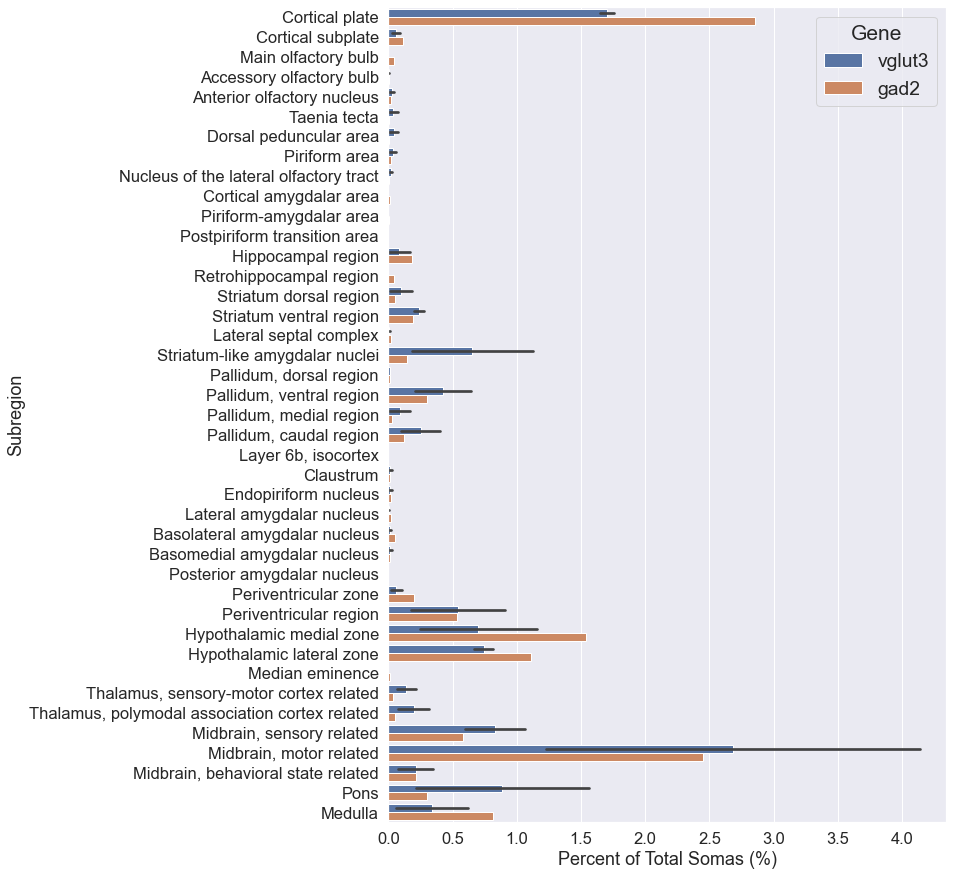

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(10, 15))
sns.set(font_scale=1.75)
sns.barplot(x = "Percent of Total Somas (%)", y = "Subregion",  hue= "Gene", data=df)
plt.show()

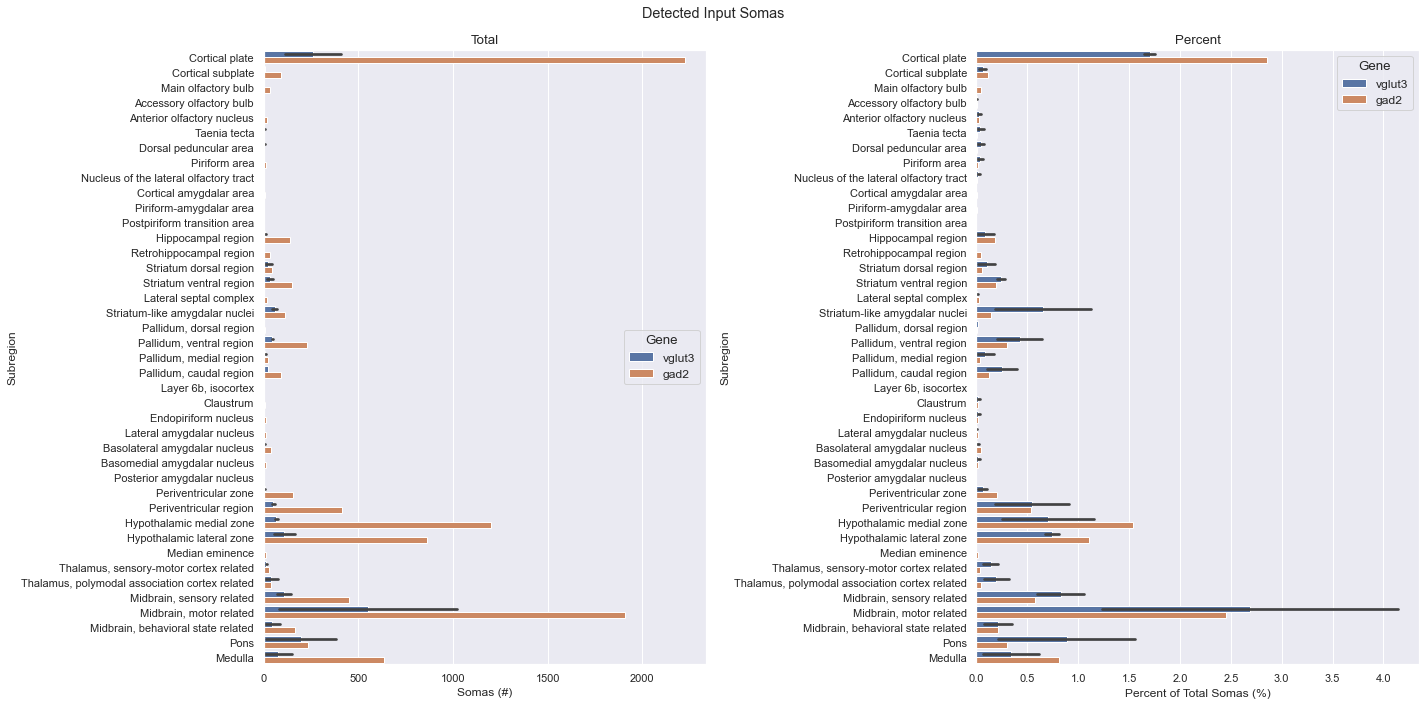

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Detected Input Somas')
sns.set(font_scale=1.1)

sns.barplot(ax = axes[0], x = "Somas (#)", y = "Subregion",  hue= "Gene", data=df)
axes[0].set_title("Total")

sns.barplot(ax = axes[1], x = "Percent of Total Somas (%)", y = "Subregion",  hue= "Gene", data=df)
axes[1].set_title("Percent")

fig.tight_layout()

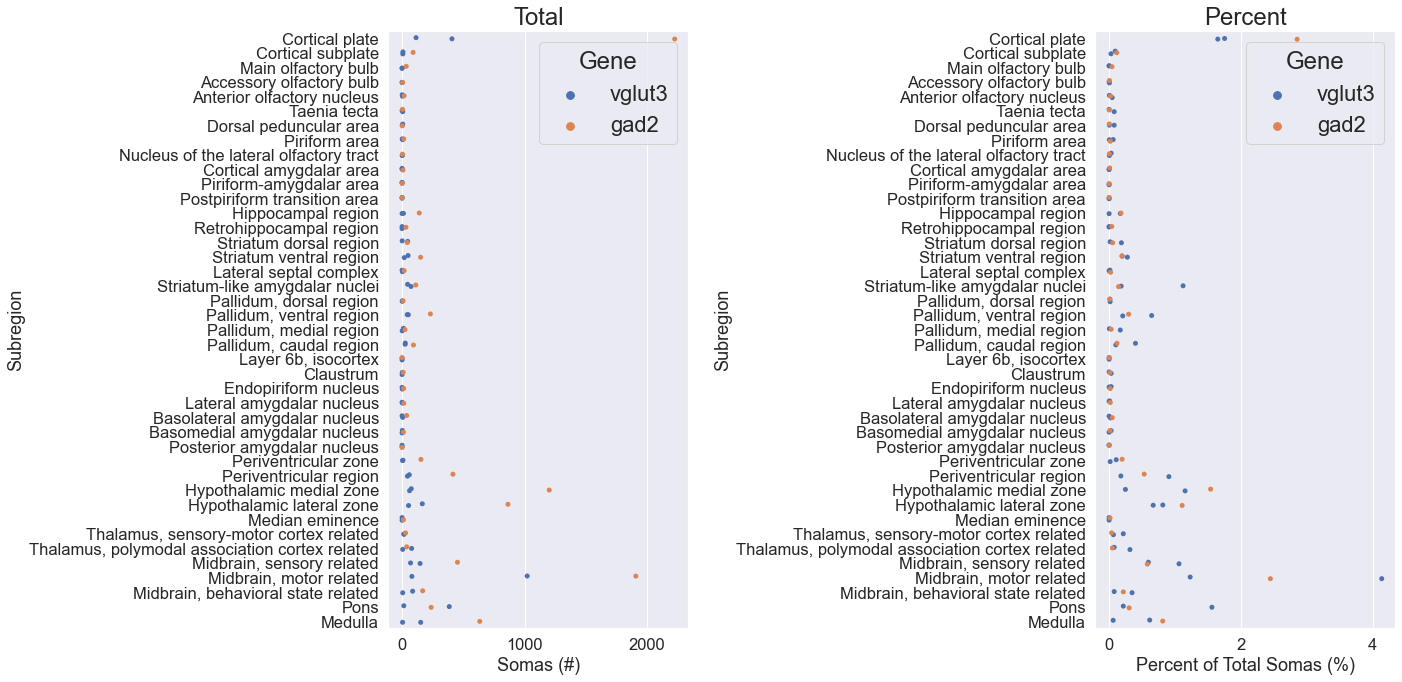

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.set(font_scale=2)

sns.stripplot(ax = axes[0], x = "Somas (#)", y = "Subregion",  hue= "Gene", data=df)
axes[0].set_title("Total")

sns.stripplot(ax = axes[1], x = "Percent of Total Somas (%)", y = "Subregion",  hue= "Gene", data=df)
axes[1].set_title("Percent")

fig.tight_layout()

### Difference

In [42]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas_diff = []
somas_diff_sd = []
somas_pct_diff = []
somas_pct_diff_sd = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        vglut =[]
        gad = []
        vglut_pct =[]
        gad_pct = []
        for brain in quantification_dicts.keys():
            if brain in ["8557", "8555"]:
                vglut.append(G.nodes[child][brain])
                vglut_pct.append(G.nodes[child][brain]/totals[brain]*100)
            else:
                gad.append(G.nodes[child][brain])
                gad_pct.append(G.nodes[child][brain]/totals[brain]*100)
            
        somas_diff.append(np.mean(gad) - np.mean(vglut))
        somas_diff_sd.append(np.sqrt(np.var(vglut) + np.var(gad)))
        somas_pct_diff.append(np.mean(gad_pct) - np.mean(vglut_pct))
        somas_pct_diff_sd.append(np.sqrt(np.var(vglut_pct) + np.var(gad_pct)))

        subregion_name.append(G.nodes[child]["name"])
        region_name.append(G.nodes[region]["name"])

d = {"Somas Difference (#)": somas_diff, "soma sd": somas_diff_sd, "Percent of Total Somas Difference (%)": somas_pct_diff, "pct sd": somas_pct_diff_sd, "Subregion": subregion_name, "Region": region_name}
df = pd.DataFrame(data = d)


Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


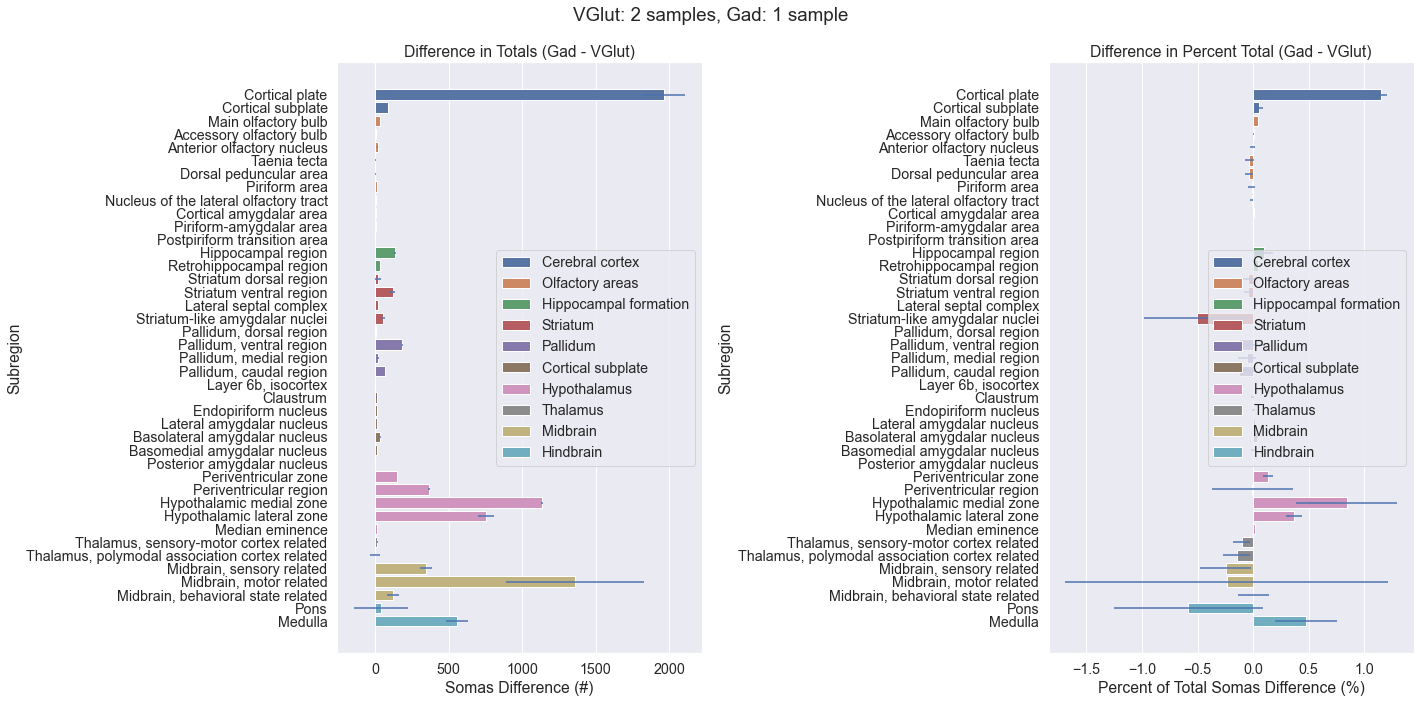

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('VGlut: 2 samples, Gad: 1 sample')

sns.set(font_scale=1.3)

p = sns.barplot(ax = axes[0], x = "Somas Difference (#)", y = "Subregion",  data=df, hue="Region", dodge=False)
axes[0].errorbar(x = df["Somas Difference (#)"], y = np.arange(df.shape[0]),  xerr=df["soma sd"], fmt='None')
axes[0].set_title("Difference in Totals (Gad - VGlut)")

p = sns.barplot(ax = axes[1], x = "Percent of Total Somas Difference (%)", y = "Subregion", data=df, hue="Region", dodge=False)
axes[1].errorbar(x = df["Percent of Total Somas Difference (%)"], y = np.arange(df.shape[0]),  xerr=df["pct sd"], fmt='None')
axes[1].set_title("Difference in Percent Total (Gad - VGlut)")

axes[0].legend(loc='center right')
axes[1].legend(loc='center right')

fig.tight_layout()

### Relative difference (coefficient of variation)

In [55]:
import itertools

totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas_reldiff = []
somas_reldiff_sd = []
somas_pct_reldiff = []
somas_pct_reldiff_sd = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        vglut =[]
        gad = []
        vglut_pct =[]
        gad_pct = []
        for brain in quantification_dicts.keys():
            if brain in ["8557", "8555"]:
                vglut.append(G.nodes[child][brain])
                vglut_pct.append(G.nodes[child][brain]/totals[brain]*100)
            else:
                gad.append(G.nodes[child][brain])
                gad_pct.append(G.nodes[child][brain]/totals[brain]*100)
            
        if np.mean(vglut) == 0:
            reldiff = 0
        else:
            reldiff = (np.mean(gad) - np.mean(vglut)) / np.mean(vglut)

        combos = list(itertools.product(gad, vglut))
        
        sum = 0
        for combo in combos:
            if combo[1] == 0:
                sum = 0
                break
            else:
                sum += (combo[0]/combo[1] - 1) ** 2

        sum = sum / len(combos)
            
        somas_reldiff.append(reldiff)
        somas_reldiff_sd.append(sum)
        #pct
        if np.mean(vglut_pct) == 0:
            reldiff = 0
        else:
            reldiff = (np.mean(gad_pct) - np.mean(vglut_pct)) / np.mean(vglut_pct)

        combos = list(itertools.product(gad_pct, vglut_pct))
        
        sum = 0
        for combo in combos:
            if combo[1] == 0:
                sum = 0
                break
            else:
                sum += (combo[0]/combo[1] - 1) ** 2

        sum = sum / len(combos)
            
        somas_pct_reldiff.append(reldiff)
        somas_pct_reldiff_sd.append(sum)

        subregion_name.append(G.nodes[child]["name"])
        region_name.append(G.nodes[region]["name"])

d = {"Somas Relative Difference": somas_reldiff, "soma sd": somas_reldiff_sd, "Percent of Total Somas Relative Difference": somas_pct_reldiff, "pct sd": somas_pct_reldiff_sd, "Subregion": subregion_name, "Region": region_name}
df = pd.DataFrame(data = d)


Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


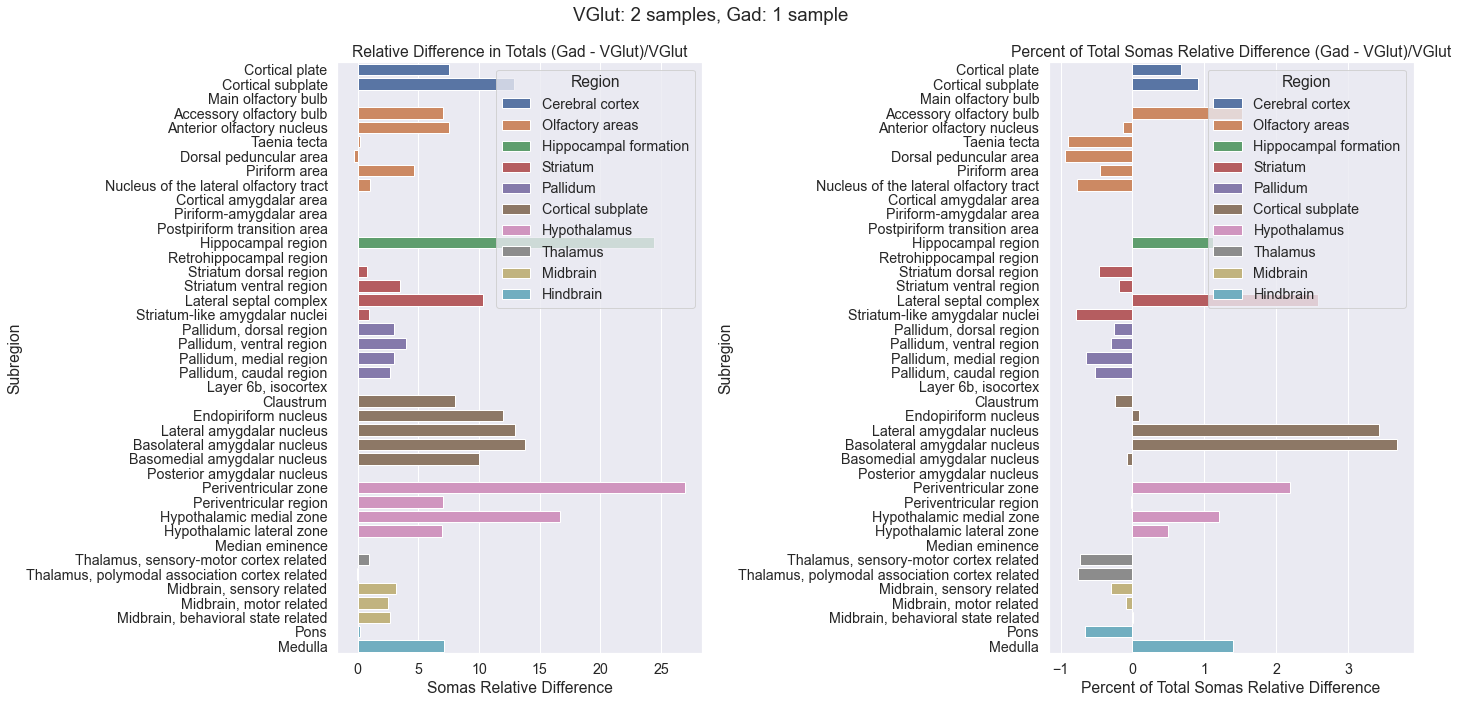

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('VGlut: 2 samples, Gad: 1 sample')

p = sns.barplot(ax = axes[0], x = "Somas Relative Difference", y = "Subregion",  data=df, hue="Region", dodge=False)
#axes.errorbar(x = df["Somas Relative Difference"], y = np.arange(df.shape[0]),  xerr=df["soma sd"], fmt='None')
axes[0].set_title("Relative Difference in Totals (Gad - VGlut)/VGlut")

p = sns.barplot(ax = axes[1], x = "Percent of Total Somas Relative Difference", y = "Subregion", data=df, hue="Region", dodge=False)
#axes[1].errorbar(x = df["Percent of Total Somas Difference (%)"], y = np.arange(df.shape[0]),  xerr=df["pct sd"], fmt='None')
axes[1].set_title("Percent of Total Somas Relative Difference (Gad - VGlut)/VGlut")


fig.tight_layout()

## Make bar charts

In [ ]:
def get_bar_info(G, color_num = 0):
    total = 0
    for node in G.nodes:
        total += G.nodes[node]["somas"]

    cmap = mpl.cm.get_cmap('tab20')

    y_pos = [0]
    width = []
    labels = []
    colors = []
    for r, region in enumerate(regions):
        
        print(f"Populating: " + G.nodes[region]["name"])
        names = []
        somas = []
        children = list(G.successors(region))
        n_entries = np.amax([len(children), 1])
        y_pos += list(np.arange(y_pos[-1]+2, y_pos[-1] + n_entries +2))
        if len(children) > 0:
            for child in children:
                labels.append(G.nodes[child]["name"])
                width.append(G.nodes[child]["somas"]/total*100)
                colors.append(cmap(2*r+color_num))
        else:
            labels.append(G.nodes[region]["name"])
            width.append(G.nodes[region]["somas"]/total*100)
            colors.append(cmap(2*r+color_num))

    y_pos = [-1*y for y in y_pos]
    y_pos = np.array(y_pos[1:])
    return y_pos, width, labels, colors


In [ ]:

height = 0.4

fig, ax = plt.subplots(figsize=(10,10))

y_pos, width, labels, colors = get_bar_info(G,0)
ax.barh(y=y_pos, width=width, height=height, tick_label = labels, color=colors, label="8557")
y_pos, width, labels, colors = get_bar_info(G3,1)
ax.barh(y=y_pos+height, width=width, height=height, tick_label = labels, color=colors, label="8607")

ax.legend()
ax.set_xlabel("Percent of total inputs (%)")


In [ ]:
labels

## Create data json

In [ ]:
def get_entry(node):
    entry = {"name": G.nodes[node]["name"]}
    successor_nodes = list(G.successors(node))
    somas = G.nodes[node]["somas"]
    
    if len(successor_nodes) > 0:
        children_somas = 0
        children = []
        for child in successor_nodes:
            children_somas += G.nodes[child]["somas"]
            child_entry = get_entry(child)
            if child_entry is not None:
                children.append(child_entry)
        if children_somas < somas:
            children.append({"name": "other", "value": somas-children_somas})
        entry["children"] = children
        return entry
    elif  somas > 0:
        entry["value"] = somas
        return entry
    else:
        return

In [ ]:
import json
for node in G.nodes:
    if G.nodes[node]['level'] == 0:
        print(node)


In [ ]:
json_string = json.dumps(get_entry(997))
print(json_string)
with open('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/d3js/somas.json', 'w', encoding='utf-8') as outfile:
    json.dump(get_entry(997), outfile, ensure_ascii=False, indent=4)

## create nested chart

In [ ]:
def sort_pairs(tosort, other):
    zipped_lists = zip(tosort, other)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    return list1, list2


In [ ]:
acros_4 = []
acros_5 = []
acros_6 = []
somas_4 = []
somas_5 = []
somas_6 = []
none = []

for node in G.nodes:
    if G.nodes[node]['st_level'] == 3:
        if G.nodes[node]['somas']>0:
            acros_4.append(G.nodes[node]['name'])
            somas_4.append(G.nodes[node]['somas'])

            children = G.successors(node)
            child_somas_counter = 0
            child_somas = []
            child_names = []

            for child in children:
                if G.nodes[child]['somas']>5:
                    child_names.append(G.nodes[child]['name'])
                    child_somas.append(G.nodes[child]['somas'])
                    child_somas_counter += G.nodes[child]['somas']


                    grandchildren = G.successors(child)
                    grandchild_somas_counter = 0
                    grandchild_somas = []
                    grandchild_names= []
                    for grandchild in grandchildren:
                        if G.nodes[grandchild]['somas']>5:
                            grandchild_names.append(G.nodes[grandchild]['name'])
                            grandchild_somas.append(G.nodes[grandchild]['somas'])
                            grandchild_somas_counter += G.nodes[grandchild]['somas']

                    if grandchild_somas_counter > G.nodes[child]['somas']:
                        raise ValueError()
                    elif grandchild_somas_counter < G.nodes[child]['somas']:
                        diff = G.nodes[child]['somas'] - grandchild_somas_counter
                        grandchild_names.append("other")
                        grandchild_somas.append(diff)

                    grandchild_somas, grandchild_names = sort_pairs(grandchild_somas, grandchild_names)
                    somas_6.extend(grandchild_somas)
                    acros_6.extend(grandchild_names)

            if child_somas_counter > G.nodes[node]['somas']:
                raise ValueError()
            elif child_somas_counter < G.nodes[node]['somas']:
                diff = G.nodes[node]['somas'] - child_somas_counter
                child_names.append("other")
                child_somas.append(diff)

            #child_somas, child_names = sort_pairs(child_somas, child_names)
            somas_5.extend(child_somas)
            acros_5.extend(child_names)



        else:
            none.append(G.nodes[node]['name'])



fig, ax = plt.subplots()

width = 1
ax.pie(somas_4, radius=1, labels = acros_4, labeldistance = 0.3,
        wedgeprops=dict(width=width, edgecolor='w'))

ax.pie(somas_5, radius=2, labels = acros_5, labeldistance = 0.6,
        wedgeprops=dict(width=width, edgecolor='w'))

ax.pie(somas_6, radius=3, labels = acros_6,
        wedgeprops=dict(width=width, edgecolor='w'))

plt.title(f"Brain R1 - {np.sum(somas_4)} Total Somas \n Inner Ring = ARA Level 3", pad=220, fontdict={'fontsize': 20})

In [ ]:
acros_4 = []
acros_5 = []
somas_4 = []
somas_5 = []
none = []

for node in G.nodes:
    if G.nodes[node]['st_level'] == 5:
        if G.nodes[node]['somas']>0:
            acros_4.append(G.nodes[node]['name'])
            somas_4.append(G.nodes[node]['somas'])

            children = G.successors(node)
            child_somas_counter = 0
            child_somas = []
            child_names = []

            for child in children:
                if G.nodes[child]['somas']>5:
                    child_names.append(G.nodes[child]['name'])
                    child_somas.append(G.nodes[child]['somas'])
                    child_somas_counter += G.nodes[child]['somas']

            if child_somas_counter > G.nodes[node]['somas']:
                raise ValueError()
            elif child_somas_counter < G.nodes[node]['somas']:
                diff = G.nodes[node]['somas'] - child_somas_counter
                child_names.append("other")
                child_somas.append(diff)

            child_somas, child_names = sort_pairs(child_somas, child_names)
            somas_5.extend(child_somas)
            acros_5.extend(child_names)



        else:
            none.append(G.nodes[node]['name'])



fig, ax = plt.subplots()

width = 2
ax.pie(somas_4, radius=width, labels = acros_4, labeldistance = 0.5,
        wedgeprops=dict(width=width, edgecolor='w'))

ax.pie(somas_5, radius=2*width, labels = acros_5, 
        wedgeprops=dict(width=width, edgecolor='w'))


plt.title(f"Brain R1 - {np.sum(somas_4)} Total Somas \n Inner Ring = ARA Level 5", pad=320, fontdict={'fontsize': 20})

In [ ]:
acros = []
somas = []
none = []
lvl = 6

for node in G.nodes:
    if G.nodes[node]['st_level'] == lvl:
        if G.nodes[node]['somas']>0:
            acros.append(G.nodes[node]['name'])
            somas.append(G.nodes[node]['somas'])
        else:
            none.append(G.nodes[node]['name'])

volumes = np.multiply(somas, 6.7/(1000**3))
plt.bar(acros,somas)
plt.ylabel("Soma Count", fontsize=20)
plt.xlabel("ARA region")
plt.title(f"Level {lvl}", fontsize=20)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)

fig = plt.gcf()
fig.set_size_inches(26, 5)
plt.show()

print(f"Areas with none detected: {none}")

In [ ]:
nodes = []
for n in G.nodes:
    if G.nodes[n]["st_level"] <= 5:
        nodes.append(n)
len(nodes)
G2 = G.subgraph(nodes)

In [ ]:
pos_dict = {}
label_dict = {}
for level in np.arange(12):
    counter = 0
    for n in G2.nodes:
        if G2.nodes[n]["st_level"] == level:
            pos_dict[n] = (100*counter, 11-level)
            counter += 1
            label_dict[n] = G2.nodes[n]["acronym"]

In [ ]:
nx.draw_networkx(G2, pos_dict, labels = label_dict, node_size=1000)


In [ ]:
net = Network(notebook=True)
net.from_nx(G2)
net.show("example.html") #only works on jupyter nb

## View transformed coords

In [62]:
import json
from cloudvolume import CloudVolume
from skimage import io
import numpy as np
from tqdm import tqdm
import napari
from skimage import measure
import scipy.ndimage as ndi
from napari_animation import AnimationWidget

In [64]:
vol = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017", mip=0, parallel=1, progress=False)
new_res = vol.resolution
og_res = [3.72, 3.72, 4]
res_factor = [i/j*1000 for i,j in zip(og_res, new_res)]
print(f"ARA Resolution: {new_res}nm")

with open("/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r1.json") as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i*j) for i,j in zip(res_factor,entry['point'])]
    points.append(point)
points_r1 = np.array(points)

with open("/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r2.json") as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i*j) for i,j in zip(res_factor,entry['point'])]
    points.append(point)
points_r2 = np.array(points)

with open("/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r3.json") as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i*j) for i,j in zip(res_factor,entry['point'])]
    points.append(point)
points_r3 = np.array(points)


#atlas = np.zeros(vol.shape, dtype=vol.dtype)

ARA Resolution: [10000 10000 10000]nm


In [65]:
atlas = io.imread("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif")

In [66]:
v = napari.Viewer()
#v.add_labels(atlas)
v.add_points(points_r1, face_color='red',size=5)
v.add_points(points_r2, face_color='orange',size=5)
v.add_points(points_r3, face_color='blue', size=5)
animation_widget = AnimationWidget(v)
v.window.add_dock_widget(animation_widget, area="right")

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. The `as_dict=True` option will be changed to `as_dict=False` in 0.4.15
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))


In [67]:
for z in [380, 680, 980]:
    slice = atlas[z,:,:]
    labels = measure.label(slice)
    borders = 0*labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype='int')
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    points_r12d = []
    for point in points_r1:
        if point[0] > z-10 and point[0] < z+10:
            points_r12d.append([point[1], point[2]])
    points_r22d = []
    for point in points_r2:
        if point[0] > z-10 and point[0] < z+10:
            points_r22d.append([point[1], point[2]])
    points_r32d = []
    for point in points_r3:
        if point[0] > z-10 and point[0] < z+10:
            points_r32d.append([point[1], point[2]])

    v = napari.Viewer()
    v.add_image(borders)
    v.add_points(points_r12d, face_color='red',size=10)
    v.add_points(points_r22d, face_color='orange',size=10)
    v.add_points(points_r32d, face_color='blue', size=10)


In [105]:
v = napari.Viewer()
v.add_image(borders)
v.add_points(points_r12d, face_color='red',size=10)
v.add_points(points_r22d, face_color='orange',size=10)
v.add_points(points_r32d, face_color='blue', size=10)
animation_widget = AnimationWidget(v)
v.window.add_dock_widget(animation_widget, area="right")

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. The `as_dict=True` option will be changed to `as_dict=False` in 0.4.15
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))


### download atlas as chunks

In [ ]:
for i in tqdm(range(0, atlas.shape[2], 10)):
    atlas[:,:,i:i+10,:] = vol[:,:,i:i+10,:]

In [ ]:
#io.imsave("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif", atlas)

## Make plots

In [ ]:
atlas.shape

In [ ]:
np.amax(points_r1,axis=0)

In [ ]:
for z in [180, 430, 680, 1030, 1280]:
    slice = atlas[z,:,:]
    labels = measure.label(slice)
    borders = 0*labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype='int')
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    
    plt.imshow(borders, cmap='gray')
    indices = np.logical_and((points_r1[:,0] <z+3), (points_r1[:,0] >z-3))
    plt.scatter(points_r1[indices,2],points_r1[indices,1], c='b', s=5)
    indices = np.logical_and((points_r3[:,0] <z+3), (points_r3[:,0] >z-3))
    plt.scatter(points_r3[indices,2],points_r3[indices,1], c='r', s=5)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('/Users/thomasathey/Desktop/' + str(z) + '.png', dpi=100)

In [ ]:
a = np.zeros((10,10,10))
b = [[1.1,1.1,1.1],[2.1,2.1,2.1]]
v = napari.Viewer()
v.add_image(a)
v.add_points(b)